In [1]:
from keras.layers import Input, Dense, Embedding, Lambda, Reshape, Flatten
from keras.models import Model
from keras.backend import mean
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
import numpy as np
from keras import backend as K

In [3]:
import keras

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
import pydot as pyd
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pyd

In [5]:
import tensorflow as tf

In [6]:
from keras_contrib.callbacks import CyclicLR

In [7]:
class NCE(keras.layers.Layer):
    def __init__(self, num_classes, neg_samples=100, **kwargs):

        self.num_classes = num_classes
        self.neg_samples = neg_samples

        super(NCE, self).__init__(**kwargs)

    # keras Layer interface
    def build(self, input_shape):

        self.W = self.add_weight(
            name="approx_softmax_weights",
            shape=(self.num_classes, input_shape[0][1]),
            initializer="glorot_normal",
        )

        self.b = self.add_weight(
            name="approx_softmax_biases", shape=(self.num_classes,), initializer="zeros"
        )

        # keras
        super(NCE, self).build(input_shape)

    # keras Layer interface
    def call(self, x):
        predictions, targets = x

        # tensorflow
        loss = tf.nn.nce_loss(
            self.W, self.b, targets, predictions, self.neg_samples, self.num_classes
        )

        # keras
        self.add_loss(K.mean(loss))

        output = K.dot(predictions, K.transpose(self.W))
        output = K.bias_add(output, self.b)

        return output

    # keras Layer interface
    def compute_output_shape(self, input_shape):
        return 1

In [205]:
max_history = 50
category_size = 100


In [206]:
hidden_layer1_size = 256
hidden_layer2_size = 128
hidden_layer3_size = 64

input_embedding_size = 64

In [207]:
purchase_cols = [x for x in range(max_history)]


In [208]:
watch_cols = [x for x in range(max_history, max_history*2)]

In [209]:
numeric_cols = [x for x in range(max_history*2, max_history*2 + 5)]

In [210]:
seq_category_cols = [purchase_cols, watch_cols]

In [211]:
single_category_cols = {105:3,106:5,107:10}   ## such as location : unique_value_size

In [230]:
embeddings = Embedding(output_dim=input_embedding_size, input_dim = category_size, 
                       input_length=max_history, mask_zero=True, name='embedding_category')

In [231]:
def seq_categorical_input(name):
    
    seq = Input(shape=(max_history,), dtype='int32', name=name)
    input_embeddings = embeddings(seq)
    avg = Lambda(lambda x: mean(x, axis=1), name='avg_' + name)
    avg_embedding = avg(input_embeddings)
    return seq, avg_embedding

In [232]:
def singe_categorical_input(name, unique_size):
    single = Input(shape=(1,), dtype='int32', name=name)
    embeddings = Embedding(output_dim=input_embedding_size, input_dim = unique_size, 
                       input_length=1, name='embedding_' + name)(single)
    #embeddings = Reshape((input_embedding_size,), name = 'reshape_' + name)(embeddings)
    embeddings = Flatten(name = 'flatten_' + name)(embeddings)
    return single, embeddings

In [233]:
def continous_input(name='numeric'):
    inp = Input(shape=(1,), dtype='float32', name=name)
    return inp, inp

In [234]:
def continous_inputs(size=None, name='numeric'):
    inp = Input(shape=(size,), dtype='float32', name=name)
    return inp, inp

In [235]:
def RecoDNN():

    seqs = []
    for i, grp in enumerate(seq_category_cols):
        seqs.append(seq_categorical_input('categorical_' + str(i)))
        
    singles = []
    for col in single_category_cols:
        singles.append(singe_categorical_input('single_'  + str(col), single_category_cols[col]))
    
    #nums = []
    #for i, grp in enumerate(numeric_cols):
        #nums.append(continous_input('numeric_' + str(i)))
    
    nums = continous_inputs(len(numeric_cols))
    
    inp_layer =  [s[0] for s in seqs]
    inp_layer += [s[0] for s in singles]
    inp_layer.append(nums[0])
    inp_embed = [s[1] for s in seqs]
    inp_embed += [s[1] for s in singles]
    inp_embed.append(nums[1])
    
    v = Dense(hidden_layer1_size, activation='relu')(keras.layers.concatenate(inp_embed)) 
    v = Dense(hidden_layer2_size, activation='relu')(v)
    v = Dense(hidden_layer3_size, activation='relu')(v)
    output = Dense(category_size, activation='softmax', name='output')(v)
    model = Model(inputs=inp_layer, outputs=[output])
    
    return model

In [20]:
def RecoDNNNCE():

    seqs = []
    for i, grp in enumerate(seq_category_cols):
        seqs.append(seq_categorical_input('categorical_' + str(i)))
        
    singles = []
    for col in single_category_cols:
        singles.append(singe_categorical_input('single_'  + str(col), single_category_cols[col]))
    
    nums = continous_inputs(len(numeric_cols))
    
    inp_layer =  [s[0] for s in seqs]
    inp_layer += [s[0] for s in singles]
    inp_layer.append(nums[0])
    inp_embed = [s[1] for s in seqs]
    inp_embed += [s[1] for s in singles]
    inp_embed.append(nums[1])
    
    targets = Input(shape=(1,), dtype="int32", name="target_ids")
    inp_layer.append(targets)
    
    v = Dense(hidden_layer1_size, activation='relu')(keras.layers.concatenate(inp_embed)) 
    v = Dense(hidden_layer2_size, activation='relu')(v)
    sm_logits = NCE(category_size, name="nce")([v, targets])
    
    model = Model(inputs=inp_layer, outputs=[sm_logits])
    
    return model

# Create Test data

In [213]:
data_size = 10000

In [214]:
#create fake data

data1 = np.random.randint(category_size, size=(data_size, max_history))
data2 = np.random.randint(category_size, size=(data_size, max_history))
single1 = np.random.randint(3, size=(data_size, 1))
single2 = np.random.randint(5, size=(data_size, 1))
single3 = np.random.randint(10, size=(data_size, 1))
num1 = np.random.random(size=(data_size, 5))

labels = np.random.randint(category_size, size=(data_size, 1))
# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(labels, num_classes=category_size)

# Test NCE LOSS

In [ ]:
model_nce = RecoDNNNCE()


In [ ]:
model_nce.summary()


In [ ]:
model_nce.compile(optimizer='adam', loss=None)


In [ ]:
model_nce.fit(x=[data1, data2, single1, single2, single3, num1, labels], epochs=150, batch_size=32)


In [ ]:
model_nce.evaluate([data1, data2, single1, single2, single3, num1, labels], batch_size=32)

# Test softmax

In [236]:
model = RecoDNN()

In [237]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
categorical_0 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
categorical_1 (InputLayer)      (None, 50)           0                                            
__________________________________________________________________________________________________
single_105 (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
single_106 (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
single_107

In [238]:
#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [239]:
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [240]:
model.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [ ]:
model.fit(x=[data1, data2, single1, single2, single3, num1], 
          y=one_hot_labels, epochs=100, batch_size=32)

In [242]:
model.evaluate([data1, data2, single1, single2, single3, num1], y=one_hot_labels, batch_size=32)

10000/10000 [==============================] - 1s 77us/step


[0.003155421318486333, 1.0]

# lr finder

In [173]:
from lr_finder import LRFinder
lr_finder = LRFinder(min_lr=1e-3, max_lr=1, steps_per_epoch=np.ceil(data_size/16), epochs=3)          

In [175]:
model.fit(x=[data1, data2, single1, single2, single3, num1], y=one_hot_labels,callbacks=[lr_finder])

Epoch 1/1
1000/1000 [==============================] - 0s 143us/step - loss: 13.3361 - acc: 0.1540


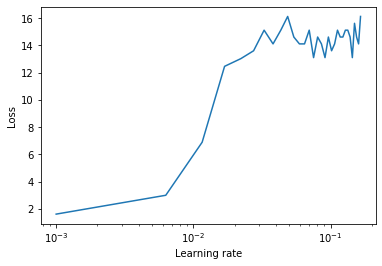

In [176]:
lr_finder.plot_loss()

# cyclic lr

In [150]:
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')

In [151]:
#clr = CyclicLR(mode='triangular')

In [177]:
model.evaluate([data1, data2, single1, single2, single3, num1], y=one_hot_labels, batch_size=32)

1000/1000 [==============================] - 0s 44us/step


[14.490167610168458, 0.101]